# Importing libraries

In [1]:
#External lebraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
from typing import Callable
from IPython.display import clear_output

In [2]:
#Internal libraries
from lib.system import HistoricalMarketSystem
from lib.simulator import Historical_EM_Simulator
from lib.util import DataBuffer
from lib.util import OptimizerSampled
from lib.model import ModelPerceptron
from lib.critic import Critic
from lib.model import GaussianPDFModelCus
from lib.policy import Policy

# Data preprocessing

In [3]:
data = pd.read_parquet("data.parquet")

columns = ['mid_price', 'bid_1_px', 'bid_1_qty', 'bid_2_qty',
       'bid_3_qty', 'bid_4_qty', 'bid_5_qty', 'ask_1_qty', 'ask_2_qty',
       'ask_3_qty', 'ask_4_qty', 'ask_5_qty', 'bid_2_px', 'bid_3_px',
       'bid_4_px', 'bid_5_px', 'ask_1_px', 'ask_2_px', 'ask_3_px', 'ask_4_px',
       'ask_5_px']

for column in columns:
    data[column] = data[column].astype(float)

In [4]:
train_data = data[:100000]
test_data = data[100000:]

# Test of our simulator

*States*:

0) `Asset`

1) `Price`

2) `Cash`

3) `Price with slippage`

4) `Cash with slippage`

## Class for main loop

In [5]:
class MonteCarloSimulationScenario:
    """Run whole REINFORCE procedure"""

    def __init__(
        self,
        train_mode: True,
        simulator: Historical_EM_Simulator,
        system: HistoricalMarketSystem,
        policy: Policy,
        critic: Critic,
        N_episodes: int,
        N_iterations: int,
        discount_factor: float = 1.0,
        termination_criterion: Callable[
            [np.array, np.array, float, float], bool
        ] = lambda *args: False,
    ):
        """Initialize scenario for main loop


        Args:
            simulator (Simulator): simulator for computing system dynamics
            system (MarketSystem): system itself
            policy (PolicyREINFORCE): REINFORCE gradient stepper
            N_episodes (int): number of episodes in one iteration
            N_iterations (int): number of iterations
            discount_factor (float, optional): discount factor for running costs. Defaults to 1
            termination_criterion (Callable[[np.array, np.array, float, float], bool], optional): criterion for episode termination. Takes observation, action, running_cost, total_cost. Defaults to lambda*args:False
        """

        self.train_mode = train_mode
        self.simulator = simulator
        self.system = system
        self.policy = policy
        self.N_episodes = N_episodes
        self.N_iterations = N_iterations
        self.termination_criterion = termination_criterion
        self.discount_factor = discount_factor
        self.data_buffer = DataBuffer()
        self.critic = critic
        self.total_cost = 0
        self.total_costs_episodic = []
        self.learning_curve = []
        self.last_observations = None
        self.toe = []

    def compute_running_cost(
        self, observation: np.array, action: np.array
    ) -> float:
        """Computes running cost

        Args:
            observation (np.array): current observation
            action (np.array): current action

        Returns:
            float: running cost value
        """

        return -(observation[1] -0.001*action[0]) * action[0] +(observation[0] <0)
    
    

    def run(self) -> None:
        """Run main loop"""

        eps = 0.1
        means_total_costs = [eps]
        self.toe = []
        self.twap = []
        for iteration_idx in range(self.N_iterations):
            if iteration_idx % 10 == 0:
                clear_output(wait=True)
            toe = []
            twap = []
            for episode_idx in tqdm(range(self.N_episodes)):
                toe1 = []
                twap1 = []
                terminated = False
                if self.train_mode:
                    r_episode_idx = np.random.randint(len(system.data)//system.N_steps[0] - 1, size = 1)[0]
                else:
                    r_episode_idx = episode_idx
                while self.simulator.step(r_episode_idx):
                    (
                        observation,
                        action,
                        step_idx,
                    ) = self.simulator.get_sim_step_data()
                    new_action = (
                        self.policy.model.sample(torch.tensor(observation[:,0]).float())
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    running_cost = self.compute_running_cost(
                        observation[:, 0], new_action
                    )
                    discounted_running_cost = (
                        self.discount_factor ** (step_idx) * running_cost
                    )
                    self.total_cost += discounted_running_cost

                    if not terminated and self.termination_criterion(
                        observation[:, 0],
                        new_action,
                        discounted_running_cost,
                        self.total_cost,
                    ):
                        terminated = True

                    if not terminated:
                        self.data_buffer.push_to_end(
                            observation=np.copy(observation[:,0]),
                            action=np.copy(new_action),
                            observation_action=np.hstack((observation[:,0], action[:1])),
                            running_cost=np.copy(running_cost),
                            discounted_running_cost=np.copy(
                                discounted_running_cost
                            ),
                            total_cost=np.copy(self.total_cost),
                            step_id=step_idx - 1,
                            episode_id=episode_idx,
                        )
                    self.system.receive_action(np.hstack((new_action,np.array([1 / (simulator.step_size * simulator.N_steps)]))))
                    toe1.append(running_cost)
                    twap1.append(observation[[2],1])
                self.simulator.reset()
                toe.append(toe1)
                twap.append(twap1)
                self.total_costs_episodic.append(self.total_cost)
                self.total_cost = 0
            self.toe = toe
            self.twap = twap
            self.learning_curve.append(np.mean(self.total_costs_episodic))
            self.last_observations = pd.DataFrame(
                index=np.array(self.data_buffer.data["episode_id"]),
                data=np.array(self.data_buffer.data["observation"]),
            )
            self.last_actions = pd.DataFrame(
                index=np.array(self.data_buffer.data["episode_id"]),
                data=np.array(self.data_buffer.data["action"]),
            )
            if self.train_mode:
                self.critic.fit(self.data_buffer)
                self.policy.REINFORCE_step(self.data_buffer)

            means_total_costs.append(np.mean(self.total_costs_episodic))
            change = (means_total_costs[-1] / means_total_costs[-2] - 1) * 100
            sign = "-" if np.sign(change) == -1 else "+"
            print(
                f"Iteration: {iteration_idx + 1} / {self.N_iterations}, "
                + f"mean total cost {round(means_total_costs[-1], 2)}, "
                + f"% change: {sign}{abs(round(change,2))}, "
                + f"last observation: {self.last_observations.groupby(self.last_observations.index).last().mean().values}, "
                + f"TWAP cash: {np.array(self.twap).mean(axis=0)[-1][0]:.3f}"
                ,
                end="\n",
            )

            self.total_costs_episodic = []

    def plot_data(self):
        """Plot learning results"""

        data = pd.Series(
            index=range(1, len(self.learning_curve) + 1), data=self.learning_curve
        )
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker="o", markersize=3)
        interpolated_values.plot(linestyle="--")

        plt.title("Total cost by iteration")
        plt.xlabel("Iteration number")
        plt.ylabel("Total cost")
        plt.show()

        data = pd.DataFrame(self.toe).mean()
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker=".", markersize=1)
        interpolated_values.plot(linestyle="--")

        plt.title("Running cost by step in last iteration")
        plt.xlabel("Step Number")
        plt.ylabel("Running cost")
        plt.show()
        N_steps = len(self.last_actions)//self.N_episodes
        self.last_observations.index = np.arange(N_steps).tolist()*self.N_episodes
        asset_ax, real_price_ax, real_cash_ax, time_ax = pd.DataFrame(
            data = self.last_observations.groupby(self.last_observations.index).mean().values,
        columns = ['position', 'price', 'cash RL', 'time']
            ).plot(
            xlabel="Step Number",
            title="Mean observations in last iteration",
            subplots=True,
            grid=True,
            )
        asset_ax.set_ylabel("normalized position")
        real_price_ax.set_ylabel("normalized price")
        real_cash_ax.set_ylabel("normalized cash")
        time_ax.set_ylabel("time left")
        real_price_ax.set_ylim(0.999, 1.001)
        tw_data = pd.DataFrame(data = np.array(self.twap).mean(axis = 0), columns = ['cash TWAP'])    
        tw_data[['cash TWAP']].plot(ax=real_cash_ax)

        
        self.last_actions.index = np.arange(N_steps).tolist()*self.N_episodes
        actions_ax = pd.DataFrame(
            data = self.last_actions.groupby(self.last_actions.index).mean().values
        ).plot(
            xlabel="Step Number",
            title="Mean actions in last iteration",
            legend=False,
            grid=True,
        )
        actions_ax.set_ylabel("action")
        
        pd.DataFrame(
            self.last_actions.groupby(self.last_actions.index).mean().values
        ).rolling(50).mean().plot(
            ax=actions_ax, legend = False
        )

        plt.show()

# Training the RL agent

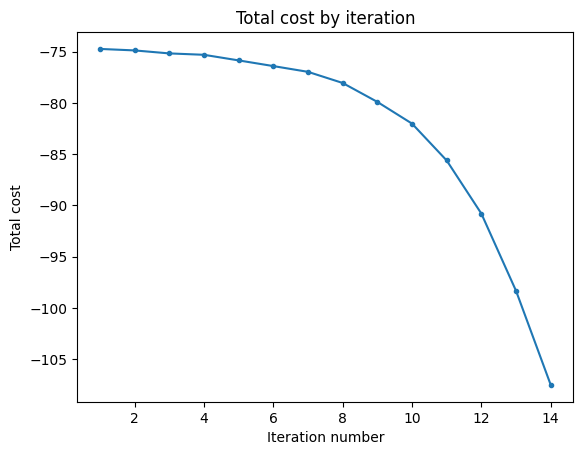

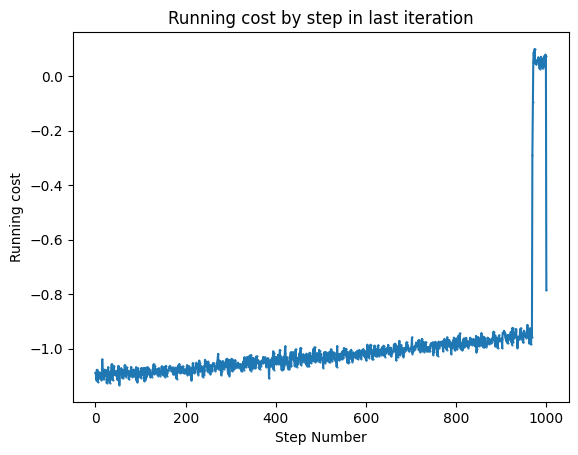

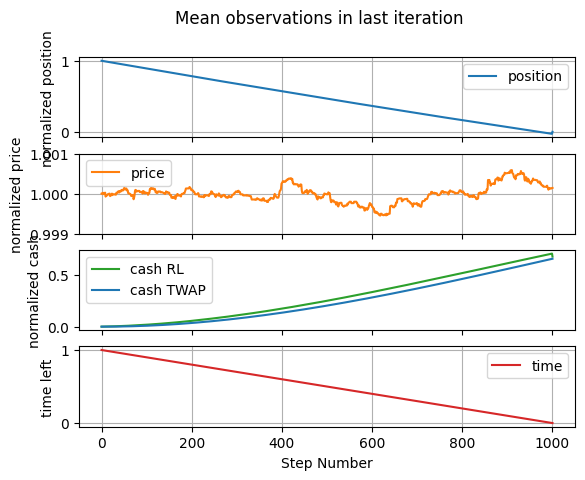

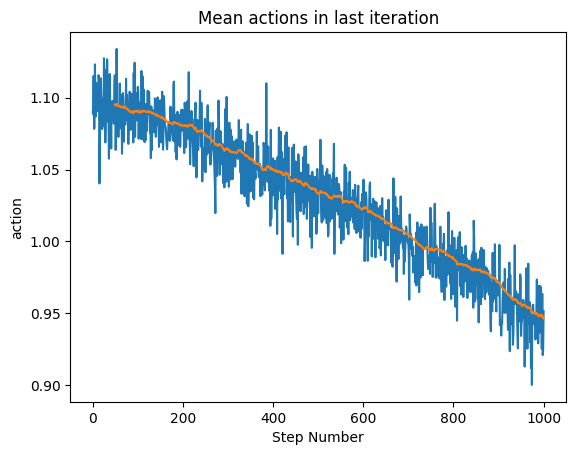

In [6]:
SEED = 0xC0FFEE
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = HistoricalMarketSystem(data=train_data, N_steps=1000, tc=0.01, inventory_risk = 0.001)

simulator = Historical_EM_Simulator(
    system, N_steps=system.N_steps[0], step_size=0.001, state_init=np.array([
        [1.,1,0, 1.001],
        [1.,1,0, 1.001]]).T
)


discount_factor = 0.99

model = GaussianPDFModelCus(
    dim_observation=system.dim_observation,
    dim_action=system.dim_action,
    action_bounds=np.array([[0, 1.5]]),
    n_hidden_layers=4,
    scale_factor=50,
    dim_hidden=5,
    std=0.05,
)
critic_model = ModelPerceptron(
    dim_input=system.dim_observation,
    dim_output=1,
    dim_hidden=5,
    n_hidden_layers=5,
)

critic_optimizer = OptimizerSampled(
    model=critic_model,
    opt_method=torch.optim.Adam,
    opt_options=dict(lr=0.045),
    n_epochs=15,
    is_reinstantiate_optimizer=True,
)

critic = Critic(
    td_n=8,
    discount_factor=discount_factor,
    device="cpu",
    model=critic_model,
    optimizer=critic_optimizer,
)

policy_optimizer = OptimizerSampled(
    model=model,
    opt_method=torch.optim.Adam,
    opt_options=dict(lr=0.045),
    is_reinstantiate_optimizer=False,
)


policy = Policy(
    model,
    policy_optimizer,
    critic=critic,
    discount_factor=discount_factor,
)

# This termination criterion never terminates episodes
trivial_terminantion_criterion = lambda *args: False

scenario = MonteCarloSimulationScenario(
    train_mode=True,
    simulator=simulator,
    system=system,
    policy=policy,
    critic=critic,
    N_episodes=6,
    N_iterations=14,
    termination_criterion=trivial_terminantion_criterion,
    discount_factor=discount_factor,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

In [7]:
print('Train Final average CASH:', scenario.last_observations.groupby(scenario.last_observations.index).mean()[2].values[-1])

print('Train TWAP final mean cash:', np.array(scenario.twap).mean(axis=0)[-1][0])

Train Final average CASH: 0.6771435079339528
Train TWAP final mean cash: 0.656152452825541


# Testing the results

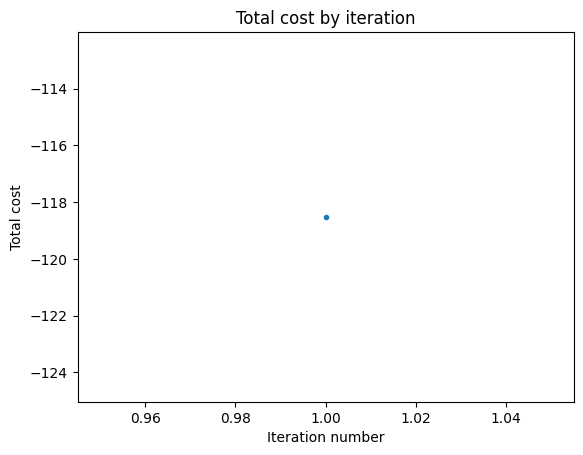

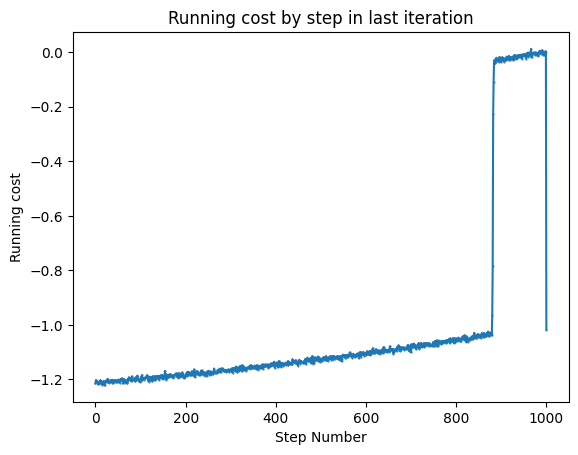

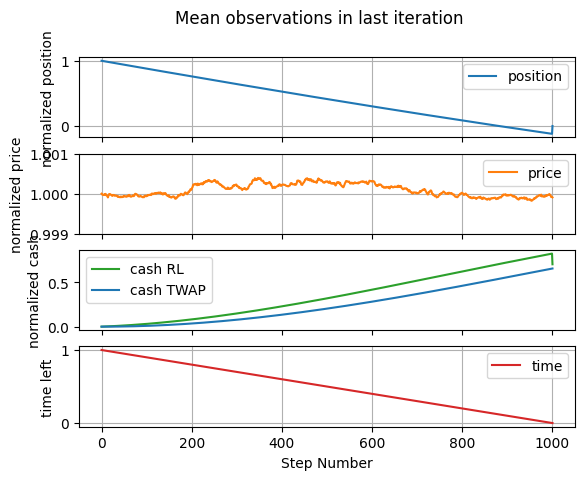

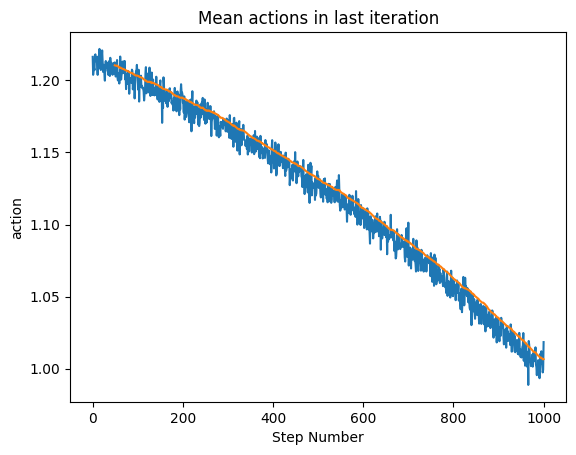

In [8]:
system = HistoricalMarketSystem(data=train_data, N_steps=1000, tc=0.01, inventory_risk = 0.001)

simulator = Historical_EM_Simulator(
    system, N_steps=system.N_steps[0], step_size=0.001, state_init=np.array([
        [1.,1,0, 1.001],
        [1.,1,0, 1.001]]).T
)

scenario2 = MonteCarloSimulationScenario(
    train_mode=False,
    simulator=simulator,
    system=system,
    policy=policy,
    critic=critic,
    N_episodes=40,
    N_iterations=1,
    termination_criterion=trivial_terminantion_criterion,
    discount_factor=discount_factor,
)

try:
    scenario2.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario2.plot_data()

clear_output(wait=True)
scenario2.plot_data()

In [9]:
print('Test Final average CASH:', scenario2.last_observations.groupby(scenario2.last_observations.index).mean()[2].values[-1])
print('Test TWAP Final average CASH:', np.array(scenario2.twap).mean(axis=0)[-1][0])

Test Final average CASH: 0.7039036028634154
Test TWAP Final average CASH: 0.6562157135857142


In [10]:
print('Test Final std CASH:', scenario2.last_observations.groupby(scenario2.last_observations.index).std()[2].values[-1])
print('Test TWAP Final std CASH:', np.array(scenario2.twap).std(axis=0)[-1][0])

Test Final std CASH: 0.0015789920449500493
Test TWAP Final std CASH: 0.0015348751499703476
